# Validation of Integrators

In [1]:
import numpy as np
from typing import Callable
from numpy.typing import NDArray


from numpy.polynomial.legendre import leggauss
import matplotlib.pyplot as plt
%matplotlib inline

## Trapezoid Rules
These are for sanity checks.

I want to see that

$$
 \int_0^{2\pi} \int_0^{y'} \int_0^R f(y) x \,dx \,dy \,dz = (2\pi) \frac{R^2}{2} \int_0^{y'} f(y) \, dy
$$



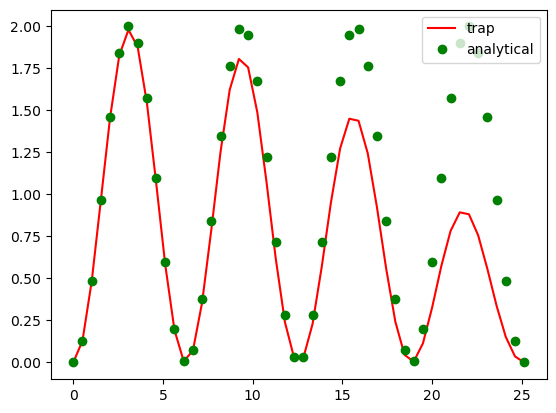

In [50]:
def trap_1d(
    fxn: Callable[[float], float],
    x_bounds: NDArray[np.float64],
    n: int = 3) -> float:

    x0, x1 = x_bounds
    h = (x1 - x0) / (n - 1)
    x = np.linspace(x0, x1, n)
    fxn_arr = fxn(x)

    return (h/2)*(fxn_arr[0] + 2 * np.sum(fxn_arr[1:n-1]) + fxn_arr[n-1])


y_vals = np.linspace(0, 8*np.pi, 50)
result_y = [trap_1d(fxn=lambda y: np.sin(y), x_bounds=np.array([0, y]), n = 10) for y in y_vals]
plt.plot(y_vals, result_y, "r-", label="trap")
plt.plot(y_vals, -np.cos(y_vals)+1, "go", label="analytical")
plt.legend()

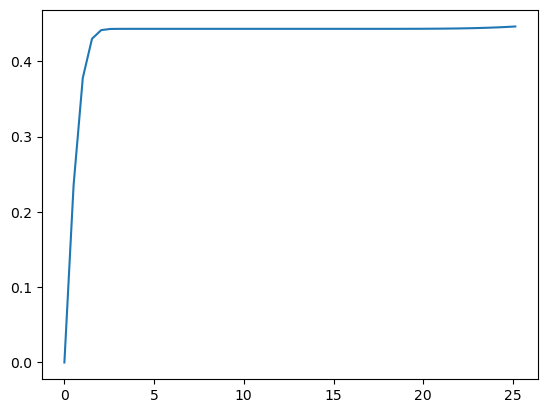

In [62]:


def trap_3d(
    fxn: Callable[[NDArray[np.float64], NDArray[np.float64], NDArray[np.float64]], NDArray[np.float64]],
    x_bounds: NDArray[np.float64],
    y_bounds: NDArray[np.float64],
    z_bounds: NDArray[np.float64],
    n: int = 5
) -> float:

    x0, x1 = x_bounds
    y0, y1 = y_bounds
    z0, z1 = z_bounds

    x = np.linspace(x0, x1, n)
    y = np.linspace(y0, y1, n)
    z = np.linspace(z0, z1, n)

    dx = (x1 - x0) / (n - 1)
    dy = (y1 - y0) / (n - 1)
    dz = (z1 - z0) / (n - 1)

    X, Y, Z = np.meshgrid(x, y, z, indexing='ij')

    f_vals = fxn(X, Y, Z)

    # Generate weight array
    weights = np.ones_like(f_vals)

    # Multiply weights by 0.5 on boundaries in each dimension
    for axis in range(3):
        slices_start = [slice(None)] * 3
        slices_end = [slice(None)] * 3

        slices_start[axis] = 0
        slices_end[axis] = -1

        weights[tuple(slices_start)] *= 0.5
        weights[tuple(slices_end)] *= 0.5

    integral = np.sum(f_vals * weights) * dx * dy * dz

    return integral

y_vals = np.linspace(0, 8*np.pi, 50)

result_y = [trap_3d(fxn=lambda x, y, z: x * np.exp(-y**2),
        x_bounds=np.array([0, 1]),
        y_bounds=np.array([0, y]),
        z_bounds=np.array([0, 1]),
        n=20) for y in y_vals]



plt.plot(y_vals, result_y)

## Quadrature Rules
Ok, now let's look at the quadrature rules and see if they do a simliar thing.

In [51]:
def linTransform(
        t:float,
        a:float,
        b:float ) -> float:
    """Linear transform from [-1,1] to [a,b]"""
    return 0.5 * ((b - a) * t + (a + b))


### THE ORIGINAL WAY I WAS DOING IT
def gaussQuad1D(
    fxn: Callable[[float], float],
    x_bounds:NDArray[np.float64],
    n:int = 3 ) -> float:
    """1-D Gaussian Quadrature using Legendre Polynomials.
    Defaults to 1 quadrature point."""
    roots, weights = leggauss(n)

    a, b = x_bounds

    sum = 0
    # perform the summation
    for i in range(n):
        # get the roots into a,b from -1,1
        u = linTransform(roots[i], a, b)
        sum += weights[i] * fxn(u)

    # multiply by the coefficents from the variable substitution
    return 0.5 * (b - a) * sum

### THE NEW WAY
def gaussQuad1D_alt(
    fxn: Callable[[float], float],
    x_bounds: NDArray[np.float64],
    n: int = 3
) -> float:
    """1-D Gaussian Quadrature using Legendre Polynomials,
    using an alternative transformation formulation."""
    roots, weights = leggauss(n)

    a, b = x_bounds
    half_span = 0.5 * (b - a)
    midpoint = 0.5 * (a + b)

    def g(t: float) -> float:
        return half_span * fxn(half_span * t + midpoint)

    sum = 0.0
    for i in range(n):
        sum += weights[i] * g(roots[i])

    return sum

In [45]:
expcos = lambda x: np.exp(x) * np.cos(x)
expsin = lambda x: x**6 - x**2 * np.sin(2*x)

print(f"ORIGINAL: {gaussQuad1D(fxn=expcos, x_bounds=np.array([-1, 1]), n=3):0.15f}")
print(f"ORIGINAL: {gaussQuad1D(fxn=expsin, x_bounds=np.array([1, 30]), n=3):0.15f}")

print(f"MODIFIED: {gaussQuad1D_alt(fxn=expcos, x_bounds=np.array([-1, 1]), n=3):0.15f}")
print(f"MODIFIED: {gaussQuad1D_alt(fxn=expsin, x_bounds=np.array([1, 30]), n=3):0.15f}")

ORIGINAL: 1.933390469264298
ORIGINAL: 3118126504.789089202880859
MODIFIED: 1.933390469264298
MODIFIED: 3118126504.789089202880859


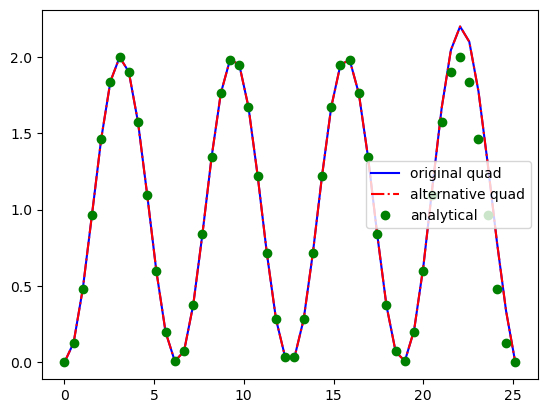

In [57]:
rad=5
x_vals = np.linspace(0, 8*np.pi, 50)
result_x = [gaussQuad1D(fxn=lambda x: np.sin(x), x_bounds=np.array([0, x]), n = 8) for x in x_vals]
result_x_alt = [gaussQuad1D_alt(fxn=lambda x: np.sin(x), x_bounds=np.array([0, x]), n = 8) for x in x_vals]

plt.plot(x_vals, result_x, "b-", label="original quad")
plt.plot(x_vals, result_x_alt, "r-.", label="alternative quad")
plt.plot(x_vals, -np.cos(x_vals)+1, "go", label="analytical")
plt.legend()
